In [7]:
# Please visit:
#
# https://download.nkg-mn.com/credo/anomalies/
#
# Pretrained dots_v2.h5 and others can be downloaded from mentioned website.
import tensorflow as tf

m = tf.keras.metrics.Accuracy()
m.update_state([[1], [2], [3], [4]], [[1], [2], [3], [4]])
m.result().numpy()

m = tf.keras.metrics.KLDivergence()
m.update_state([[1], [2], [3], [4]], [[1], [2], [3], [3]])
m.result().numpy()


KeyboardInterrupt: 

In [2]:
from commons import *
from dataset_loader import load_from_file
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

DOTS_DST = 'cache/dots_v3.pickle'
TRACKS_DST = 'cache/tracks_v3.pickle'
WORMS_DST = 'cache/worms_v3.pickle'
ARTIFACTS_DST = 'cache/artifacts_v3.pickle'

DOTS_AC = 'cache/dots_v3_vae.h5'
TRACKS_AC = 'cache/tracks_v3_vae.h5'
WORMS_AC = 'cache/worms_v3_vae.h5'
ARTIFACTS_AC = 'cache/artifacts_v3_vae.h5'


import tensorflow
import numpy
import matplotlib.pyplot

img_size = 64
num_channels = 1
latent_space_dim = 16


In [3]:
def create_vae(img_size, latent_space_dim):

    # Encoder
    x = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="encoder_input")

    encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
    encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
    encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

    encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
    encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
    encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

    encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
    encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
    encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

    encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
    encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
    encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

    encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
    encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
    encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

    shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
    encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

    encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
    encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

    encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

    def sampling(mu_log_variance):
        mu, log_variance = mu_log_variance
        epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
        random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
        return random_sample

    encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

    encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")
    encoder.summary()

    # Decoder
    decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
    decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
    decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

    decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
    decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
    decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

    decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_2")(decoder_activ_layer1)
    decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
    decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

    decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=2, name="decoder_conv_tran_3")(decoder_activ_layer2)
    decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
    decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

    decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
    decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )

    decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
    decoder.summary()

    # VAE
    vae_input = tensorflow.keras.layers.Input(shape=(img_size, img_size, num_channels), name="VAE_input")
    vae_encoder_output = encoder(vae_input)
    vae_decoder_output = decoder(vae_encoder_output)
    vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
    vae.summary()

    # compile VAE
    def loss_func(encoder_mu, encoder_log_variance):
        def vae_reconstruction_loss(y_true, y_predict):
            print('vae_reconstruction_loss', y_true, y_predict)
            reconstruction_loss_factor = 1000
            reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
            return reconstruction_loss_factor * reconstruction_loss

        def vae_kl_loss(encoder_mu, encoder_log_variance):
            print('vae_kl_loss', encoder_mu, encoder_log_variance)
            kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
            return kl_loss

        def vae_kl_loss_metric(y_true, y_predict):
            print('vae_kl_loss_metric', y_true, y_predict)
            kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
            return kl_loss

        def vae_loss(y_true, y_predict):
            print('vae_loss', y_true, y_predict)
            reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
            kl_loss = vae_kl_loss(y_true, y_predict)

            loss = reconstruction_loss + kl_loss
            return loss

        return vae_loss, vae_kl_loss_metric

    loss, metric = loss_func(encoder_mu, encoder_log_variance)

    vae.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss=loss, metrics=['accuracy', 'mean_squared_error', 'kullback_leibler_divergence'])
    return encoder, decoder, vae

In [4]:
def train_and_test(train_set, validation_set, fn):
    encoder, decoder, vae = create_vae(img_size, latent_space_dim)
    #autoencoder = train_or_cache(train_set, autoencoder, fn, validation_set=validation_set, force_train=True)
    H = vae.fit(train_set, train_set, epochs=EPOCHS, batch_size=BS, shuffle=True, validation_data=(validation_set, validation_set))
    if fn is not None:
        vae.save(fn)
        encoder.save_weights(fn.replace('.h5', '_encoder_weights.h5'))
        decoder.save_weights(fn.replace('.h5', '_decoder_weights.h5'))
        print('Saved in: %s' % fn)

    N = np.arange(0, EPOCHS)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["loss"], label="train_loss")
    if validation_set is not None:
        plt.plot(N, H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig(fn.replace('.h5', '_loss.png'))

    N = np.arange(0, EPOCHS)
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(N, H.history["accuracy"], label="accuracy")
    if validation_set is not None:
        plt.plot(N, H.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig(fn.replace('.h5', '_accuracy.png'))

    for df_func, df_name in zip(
            [dm_func_mean],
            ['mean']
    ):
        for img_set, set_names in zip([validation_set], ['train']):
            encoded = encoder.predict(img_set)
            decoded = decoder.predict(encoded)

            vis, errors = visualize_predictions(decoded, img_set, df_func, False, 16)
            img_path = fn.replace('.h5', '-vis.png')
            hist_path = fn.replace('.h5', '-hist.png')
            cv2.imwrite(img_path, vis)
            display(Image.open(img_path))
            if len(img_set) > 256:
                vis, errors = visualize_predictions(decoded, img_set, df_func, False)
                img_path = fn.replace('.h5', '-vis_full.png')
                cv2.imwrite(img_path, vis)

            plt.figure(figsize=(8,6))
            plt.hist(errors, bins=100, alpha=0.5, label=set_names)
            plt.xlabel("Data", size=14)
            plt.ylabel("Count", size=14)
            plt.title(df_name)
            plt.legend(loc='upper right')
            plt.savefig(hist_path)


def load_and_train(src, out):
    images, augmented = load_from_file(src)
    train_and_test(np.expand_dims(augmented, axis=-1), np.expand_dims(images, axis=-1), out)

Model: "encoder_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 64, 64, 1)    10          ['encoder_input[0][0]']          
                                                                                                  
 encoder_norm_1 (BatchNormaliza  (None, 64, 64, 1)   4           ['encoder_conv_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 encoder_leakyrelu_1 (LeakyReLU  (None, 64, 64, 1)   0           ['encoder_norm_1[0][0

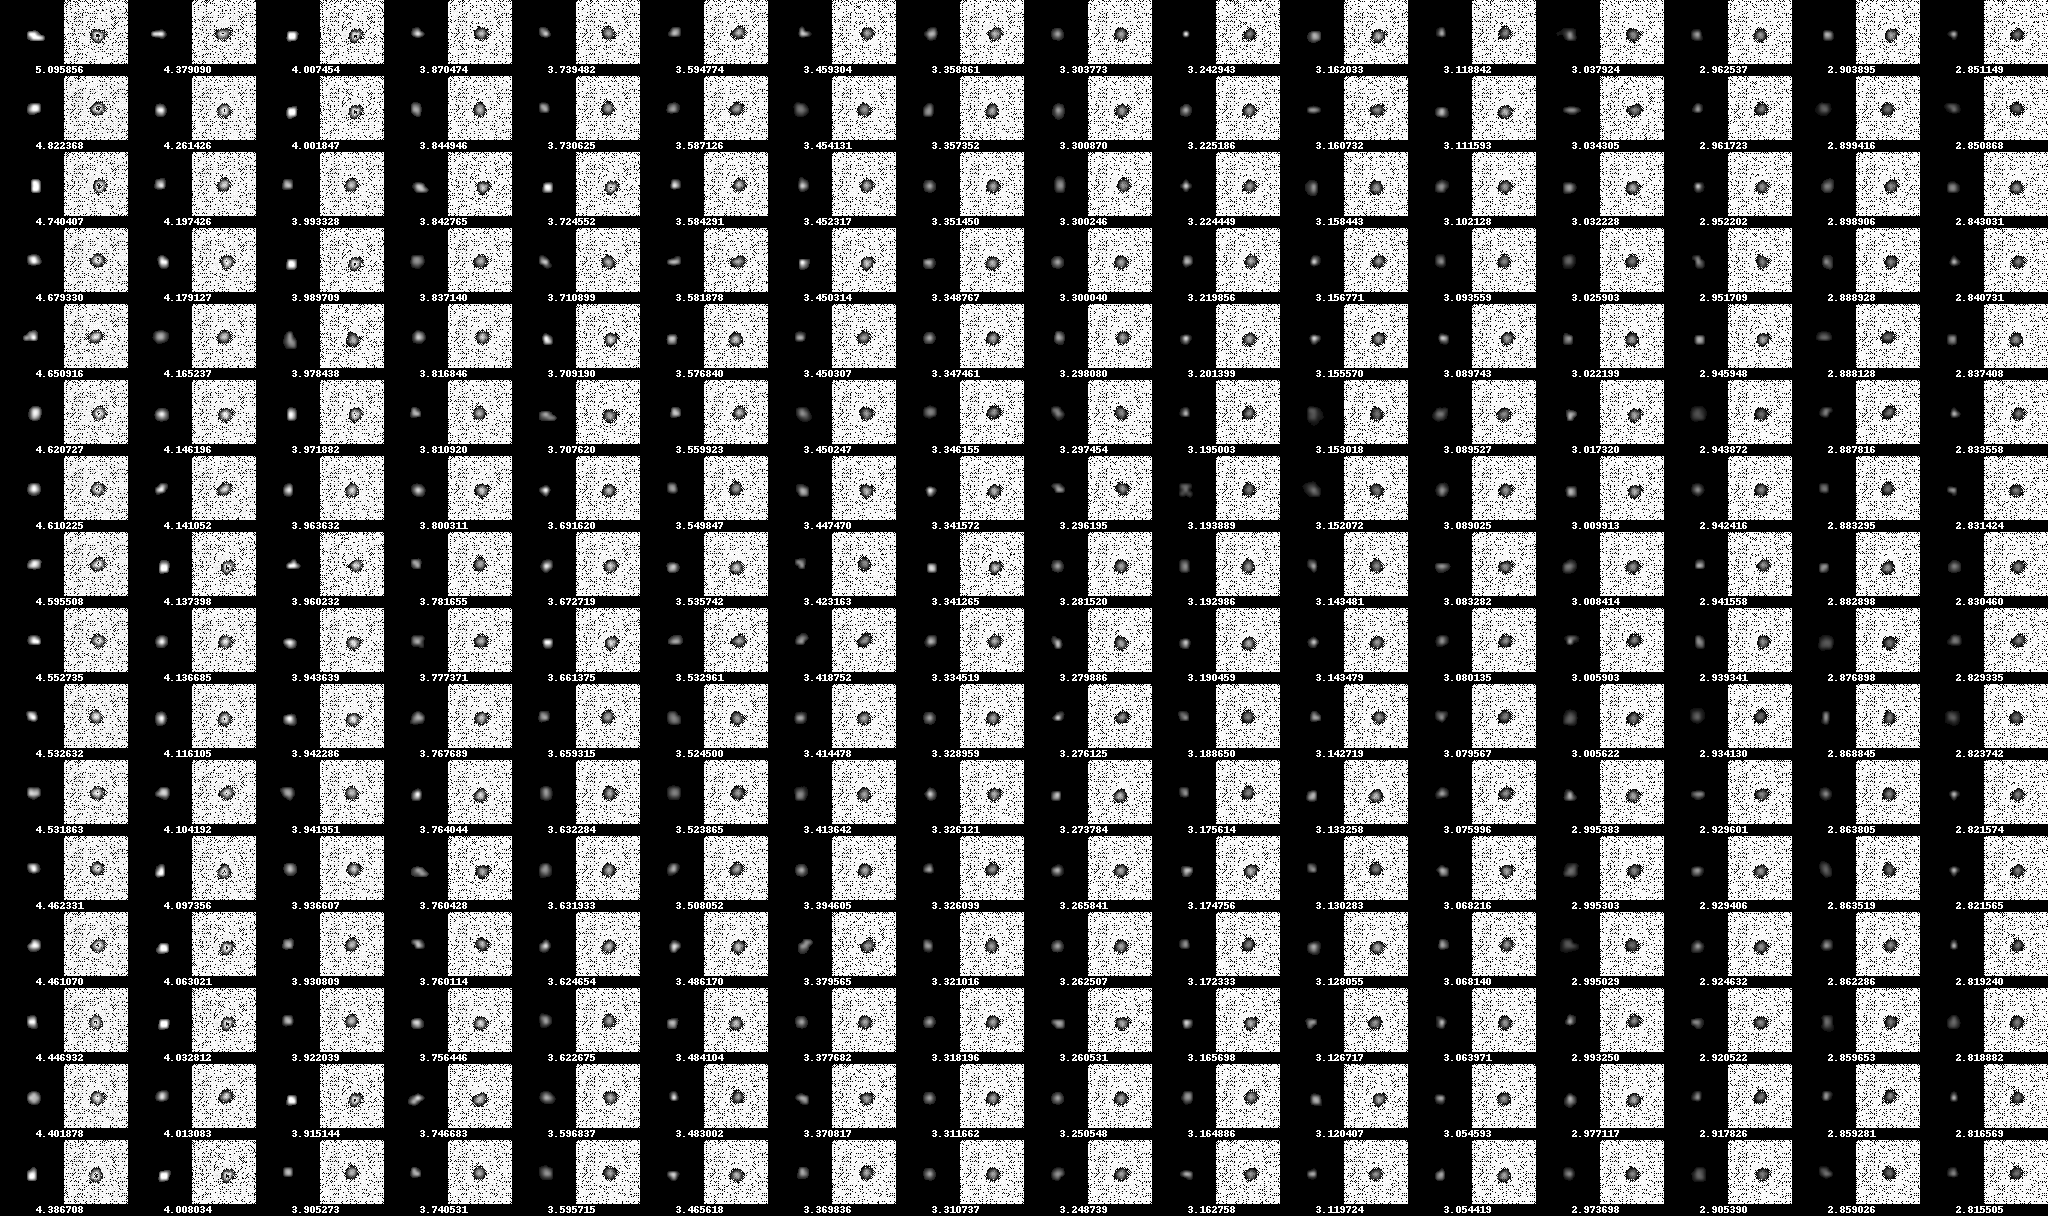

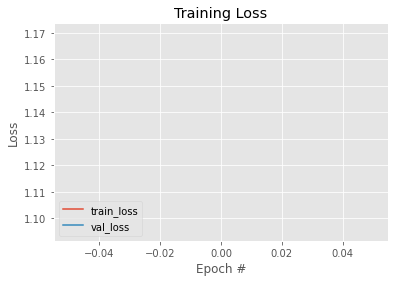

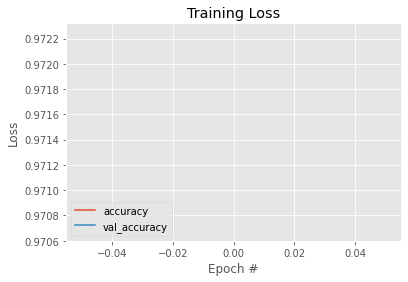

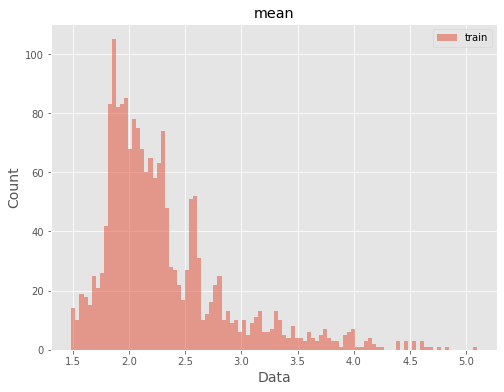

In [5]:
load_and_train(DOTS_DST, DOTS_AC)

320
0
128
18496
0
256
0
262160
278528
0
36928
0
256
18464
0
128
289
Epoch 1/200
2108/2108 [==============================] - 27s 13ms/step - loss: 0.0123 - accuracy: 0.9285 - val_loss: 0.0094 - val_accuracy: 0.9323
Epoch 2/200
2108/2108 [==============================] - 26s 12ms/step - loss: 0.0090 - accuracy: 0.9305 - val_loss: 0.0092 - val_accuracy: 0.9323
Epoch 3/200
2108/2108 [==============================] - 26s 12ms/step - loss: 0.0086 - accuracy: 0.9306 - val_loss: 0.0029 - val_accuracy: 0.9359
Epoch 4/200
2108/2108 [==============================] - 25s 12ms/step - loss: 0.0013 - accuracy: 0.9336 - val_loss: 5.7646e-04 - val_accuracy: 0.9362
Epoch 5/200
2108/2108 [==============================] - 27s 13ms/step - loss: 4.8941e-04 - accuracy: 0.9338 - val_loss: 5.1908e-04 - val_accuracy: 0.9362
Epoch 6/200
2108/2108 [==============================] - 26s 12ms/step - loss: 4.5633e-04 - accuracy: 0.9338 - val_loss: 5.5291e-04 - val_accuracy: 0.9362
Epoch 7/200
2108/2108 [=======

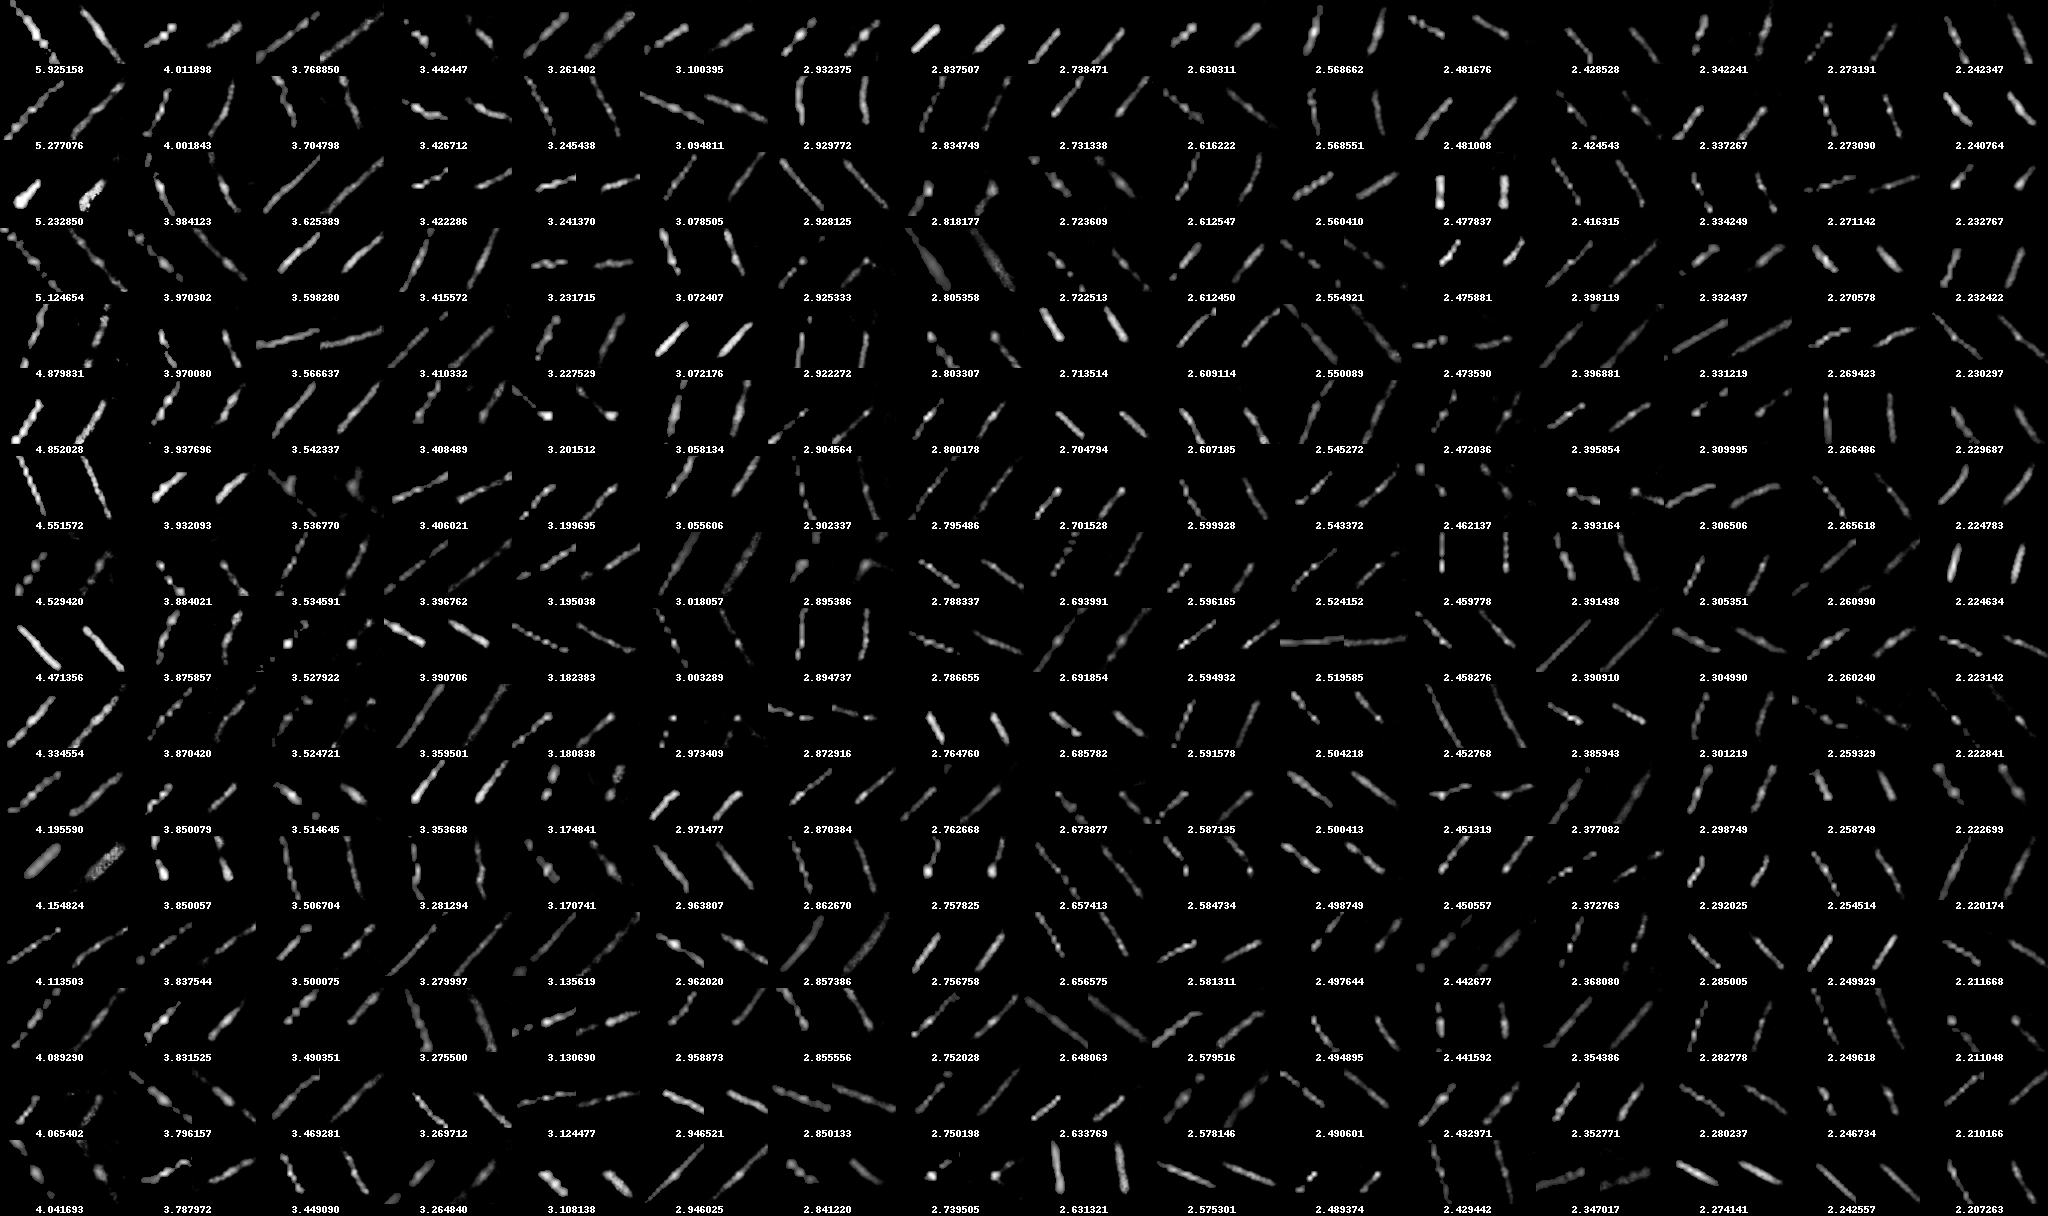

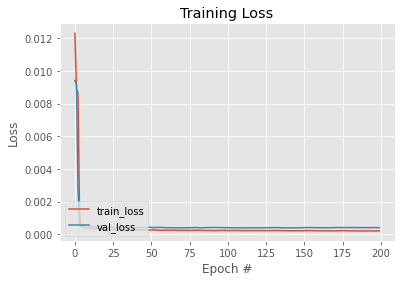

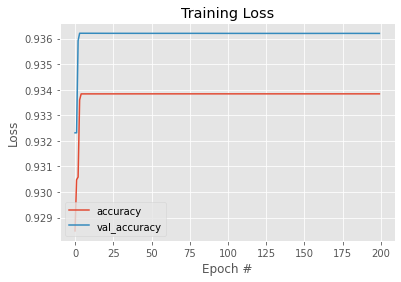

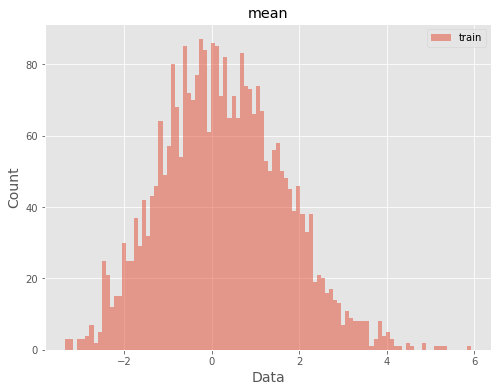

In [4]:
load_and_train(TRACKS_DST, TRACKS_AC)

320
0
128
18496
0
256
0
262160
278528
0
36928
0
256
18464
0
128
289
Epoch 1/200
341/341 [==============================] - 4s 11ms/step - loss: 0.0391 - accuracy: 0.8885 - val_loss: 0.0318 - val_accuracy: 0.9001
Epoch 2/200
341/341 [==============================] - 4s 11ms/step - loss: 0.0199 - accuracy: 0.9019 - val_loss: 0.0226 - val_accuracy: 0.9024
Epoch 3/200
341/341 [==============================] - 4s 11ms/step - loss: 0.0152 - accuracy: 0.9038 - val_loss: 0.0153 - val_accuracy: 0.9056
Epoch 4/200
341/341 [==============================] - 4s 11ms/step - loss: 0.0128 - accuracy: 0.9046 - val_loss: 0.0148 - val_accuracy: 0.9059
Epoch 5/200
341/341 [==============================] - 4s 11ms/step - loss: 0.0106 - accuracy: 0.9063 - val_loss: 0.0045 - val_accuracy: 0.9150
Epoch 6/200
341/341 [==============================] - 4s 11ms/step - loss: 0.0036 - accuracy: 0.9113 - val_loss: 0.0036 - val_accuracy: 0.9157
Epoch 7/200
341/341 [==============================] - 4s 11ms/step 

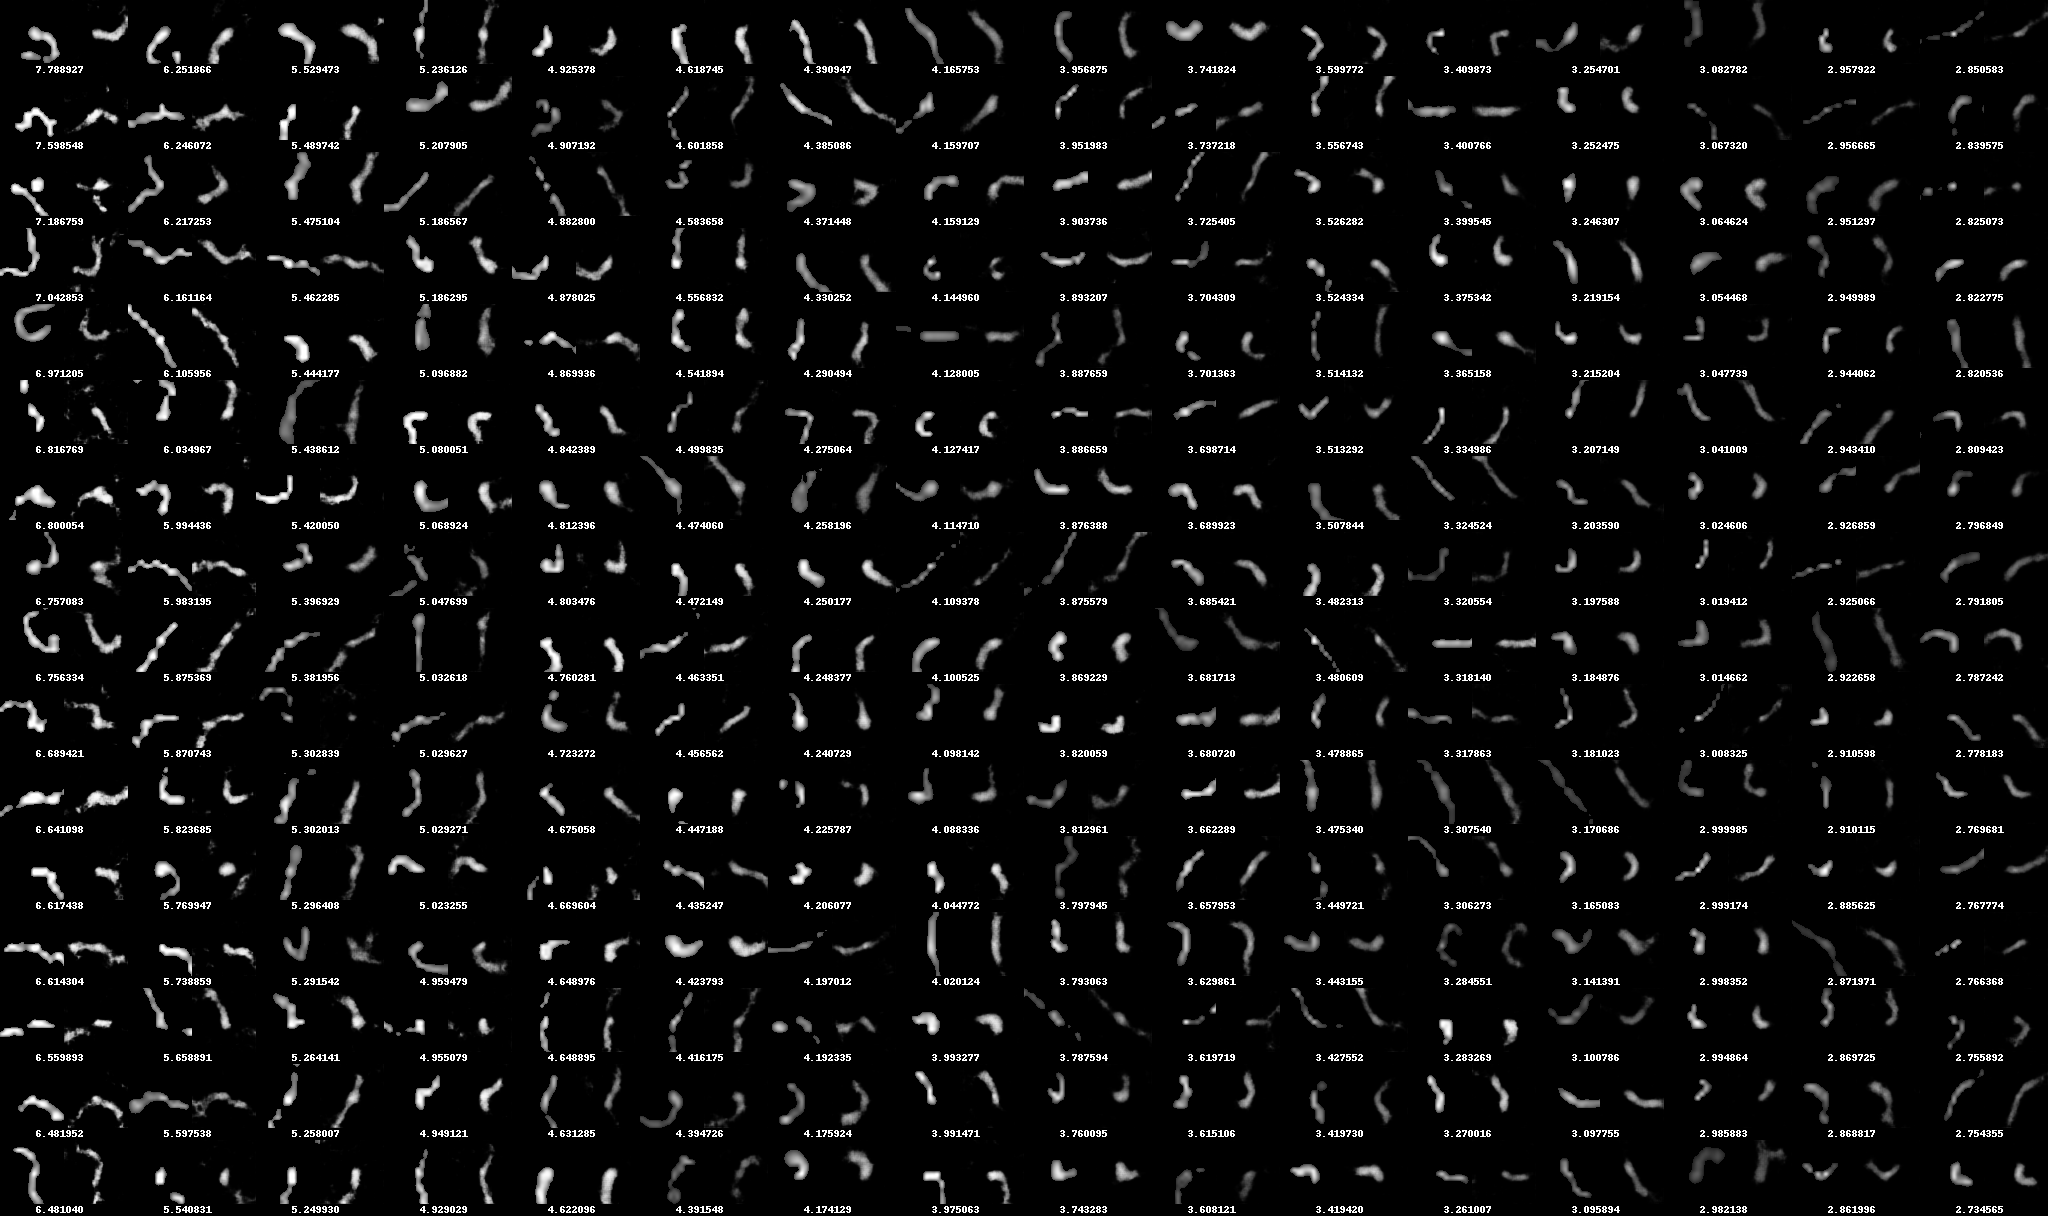

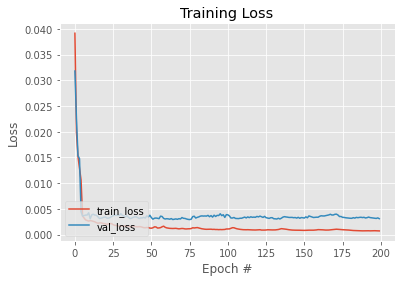

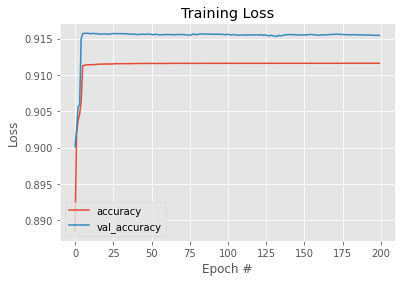

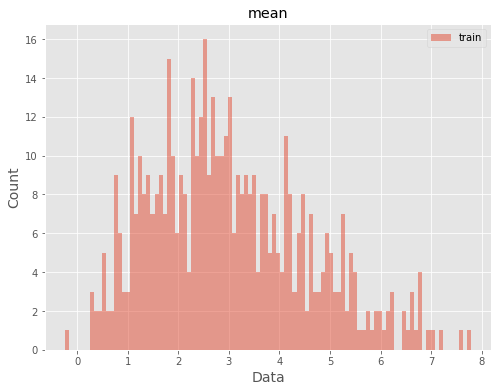

In [5]:
load_and_train(WORMS_DST, WORMS_AC)

320
0
128
18496
0
256
0
262160
278528
0
36928
0
256
18464
0
128
289
Epoch 1/200
445/445 [==============================] - 6s 12ms/step - loss: 0.0294 - accuracy: 0.9257 - val_loss: 0.0068 - val_accuracy: 0.9445
Epoch 2/200
445/445 [==============================] - 5s 12ms/step - loss: 0.0062 - accuracy: 0.9426 - val_loss: 0.0048 - val_accuracy: 0.9457
Epoch 3/200
445/445 [==============================] - 5s 12ms/step - loss: 0.0042 - accuracy: 0.9430 - val_loss: 0.0038 - val_accuracy: 0.9457
Epoch 4/200
445/445 [==============================] - 5s 12ms/step - loss: 0.0031 - accuracy: 0.9430 - val_loss: 0.0024 - val_accuracy: 0.9456
Epoch 5/200
445/445 [==============================] - 5s 12ms/step - loss: 0.0023 - accuracy: 0.9430 - val_loss: 0.0028 - val_accuracy: 0.9457
Epoch 6/200
445/445 [==============================] - 5s 12ms/step - loss: 0.0021 - accuracy: 0.9430 - val_loss: 0.0021 - val_accuracy: 0.9457
Epoch 7/200
445/445 [==============================] - 5s 12ms/step 

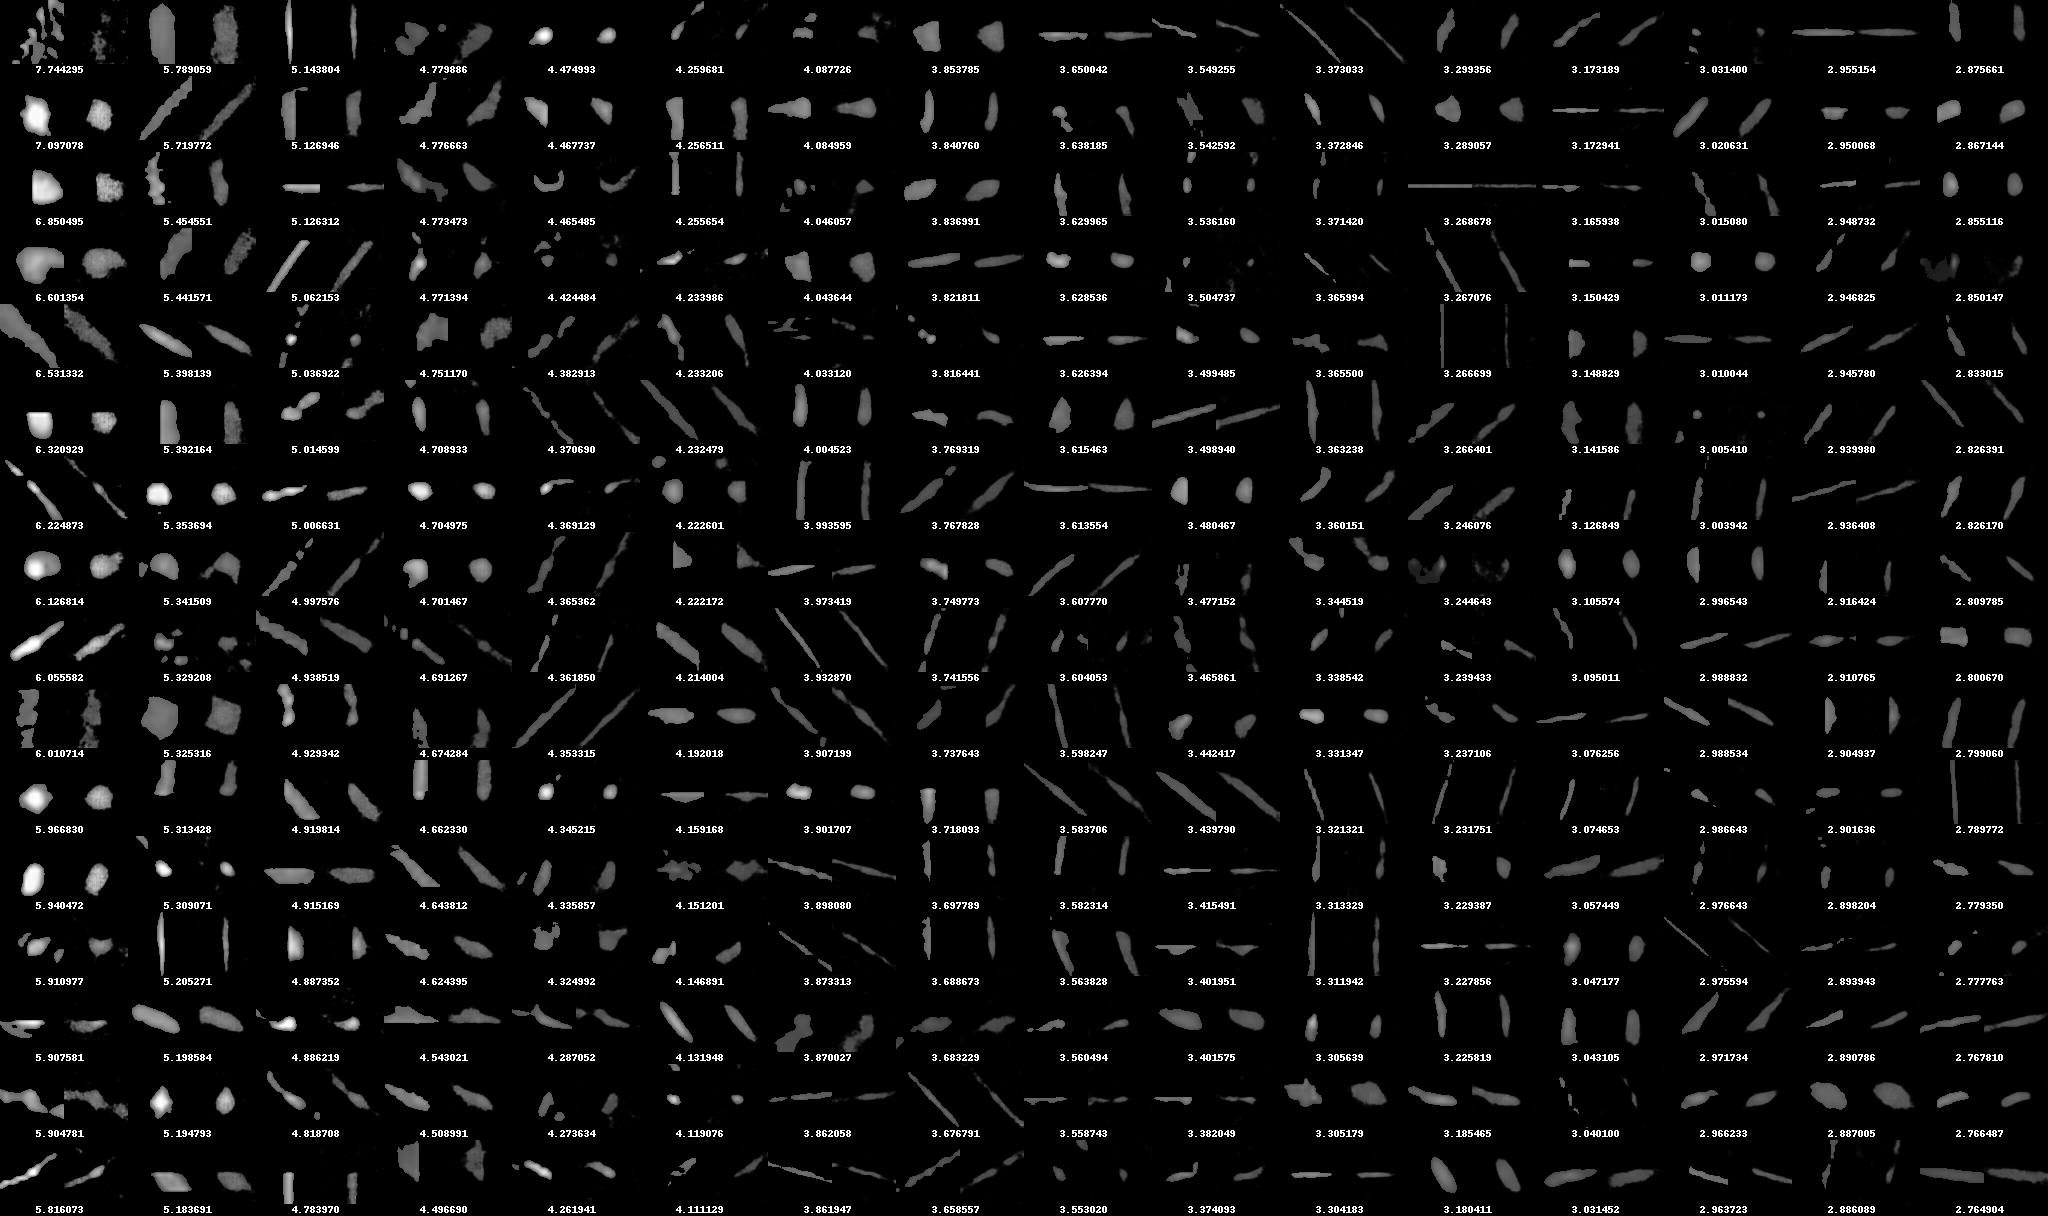

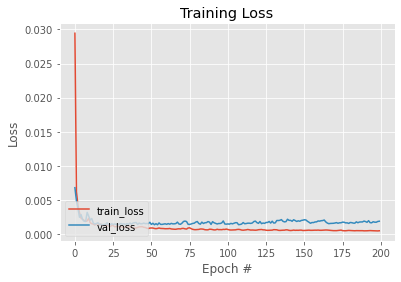

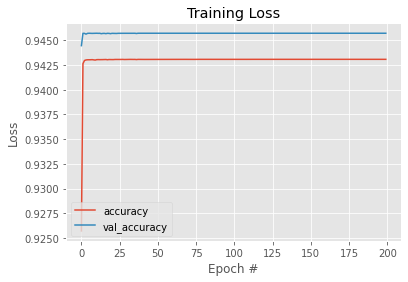

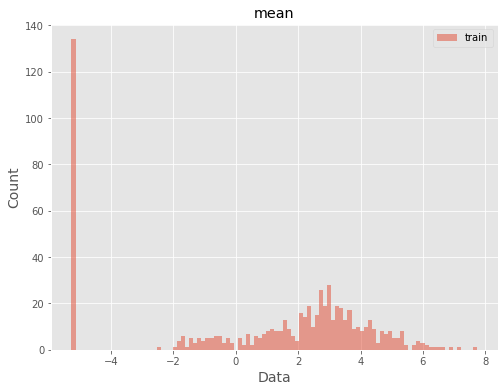

In [6]:
load_and_train(ARTIFACTS_DST, ARTIFACTS_AC)